In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ERG 131] Homework 9: Classification
----

This homework will build on the methods introduced in lab 9 that predict qualitative variables. Besides logistic regression and KNN, which were explored in lab 9, decision trees are another powerful prediction method and are easy to interpret. A decision tree can explain exactly why a specific prediction was made. As we'll see in this lab, using a single decision tree to make a prediction often isn't the best performing method. However, ensemble methods such as random forests and bagging use multiple trees to reach a "consensus" decision, and typically perform better than single decision trees. In this homework, we'll start by building a single decision tree and then see how ensemble methods perform by comparison.

Trees are, overall, a relatively accessible method for predictive modeling since they are used for both regression and classification and can take in both continuous and categorical data. Decision trees are covered in sections 8.1-8.3 of ISLR.

In this homework, we'll be doing a brief exploration of the CalEnviroScreen dataset, testing out how to make a tree from scratch, as well as implementing various ensemble methods using scikit-learn. It'll be a comprehensive survey of trees and the multitude of algorithms that arise from one tree!


### Table of Contents

1. [The data](#data) <br>
1. [Decision trees from scratch](#scratch) <br>
1. [Implementing decision trees with scikit-learn](#sk) <br>
1. [Ensemble methods](#improve) <br>
1. [Project](#project)

**Dependencies:**

In [1]:
# Load dependencies
import urllib
import os.path
from shutil import copyfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Install packages
!pip install xlrd
!pip install graphviz

  Using cached https://files.pythonhosted.org/packages/b0/16/63576a1a001752e34bf8ea62e367997530dc553b689356b9879339cf45a4/xlrd-1.2.0-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/f5/74/dbed754c0abd63768d3a7a7b472da35b08ac442cf87d73d5850a6f32391e/graphviz-0.13.2-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Section 1: The data <a name='data'></a>

In this homework, we will be working with the [California Communities Environmental Health Screening Tool (CalEnviroScreen)](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30), which uses demographic and environmental information to identify communities that are susceptible to various types of pollution. The various variables in this dataset contribute to the CES score, which reflects a community's environmental conditions and its vulnerability to environmental pollutants.

Although this dataset scores around 8000 of census tracts in California, we'll focus on a subset which makes the decision tree slightly more interpretable. 

Your HW9 folder contains an Excel file downloaded from [here](https://oehha.ca.gov/media/downloads/calenviroscreen/document/ces3results.xlsx).

Documentation on Pandas' Excel methods can be found [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html#pandas.read_excel). Start by running the cell below, which creates an Excel file object in Pandas that we can then inspect. The cell below shows you the sheet names in the spreadsheet.

In [3]:
# run this cell
filename = 'ces3results.xlsx'
xl = pd.ExcelFile(filename)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

['CES 3.0 (2018 Update)', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


**Question 1.1** Load the first sheet of the Excel file and assign it to the variable `df0`. If you're unsure of where to start, look at the link above to documentation on Excel methods in Pandas.

In [5]:
# SOLUTION
df0 = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df0.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


Before we explore this dataset, look at some of the features -- notice that this dataset doesn't include the units of most of its features. Let's take a look at a different sheet.

Run the following cell to load the data dictionary.

In [6]:
dd = xl.parse('Data Dictionary', header = 6)
dd.head(10)

,Variable Name,Description,CalEnviroScreen Category
0,Census Tract,Census Tract ID from 2010 Census,NaN
1,Total Population,2010 population in census tracts,NaN
2,California County,California county that the census tract falls ...,NaN
3,ZIP,Postal ZIP Code that the census tract falls wi...,NaN
4,Nearby City \n(to help approximate location only),City or nearby city the census tract falls wi...,NaN
5,Longitude,Longitude of the centroid of the census tract,NaN
6,Latitude,Latitude of the centroid of the census tract,NaN
7,CES 3.0 Score,"CalEnviroScreen Score, Pollution Score multipl...",NaN
8,CES 3.0 Percentile,Percentile of the CalEnviroScreen score,NaN
9,CES 3.0 Percentile Range,"Percentile of the CalEnviroScreen score, group...",NaN


Before we move on, let's check the sheet we just loaded. 

**Question 1.2** Does the number of columns in the first sheet (loaded to `df0`) correspond with the number of variables in the data dictionary? Your answer should return a boolean value.

*Hint:* There are more rows in the `dd` than there are variables defined in that dictionary! You should inspect the dataframe `dd` to see why that is, and write your Boolean expression so that it considers the number of variable names in `dd` rather than the number of rows in `dd`.

In [8]:
#SOLUTION
dd[dd["Variable Name"].notnull()].shape[0] == df0.shape[1]

True

Let's take a look at the data for Alameda County.

**Question 1.3** Find all instances that Alameda County appears in the dataset and assign it to the variable `alameda`. Then, select the columns `Census Tract`, `ZIP`, `CES 3.0 Score`, `Housing Burden`, `Poverty`, `Pesticides`, `Groundwater Threats`, and `Pollution Burden`, and assign the resulting table to `alameda_ft`.

*Hint:* Before you subset the dataframe `df0`, you will want to perform some data cleaning to remove trailing and leading spaces from the county names.  There is a `pandas` method that will do that for you automatically.

In [10]:
# SOLUTION
df0["California County"] = df0["California County"].str.strip()
alameda = df0[df0['California County'] == 'Alameda']
alameda_ft = alameda[['Census Tract', 'ZIP', 'CES 3.0 Score', 'Housing Burden', 'Poverty', 
                        'Pesticides', 'Groundwater Threats', 'Pollution Burden']]
alameda_ft.head(10)

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Poverty,Pesticides,Groundwater Threats,Pollution Burden
245,6001409000,94621,61.560437,32.5,52.5,0.0,118.50,57.413064
287,6001409100,94603,59.868084,29.5,55.8,0.0,25.10,54.143340
300,6001408800,94621,59.647241,35.2,66.5,0.0,37.65,50.360950
517,6001409200,94603,55.292008,27.4,44.4,0.0,28.00,54.957476
701,6001407300,94601,52.539247,21.4,56.3,0.0,183.05,56.830015
769,6001409500,94621,51.441952,27.6,64.2,0.0,40.85,44.367354
862,6001406000,94606,50.284331,31.0,61.9,0.0,144.80,52.302911
926,6001402200,94607,49.455273,29.3,56.8,0.0,137.25,54.195855
950,6001409400,94603,49.223471,35.9,65.7,0.0,56.05,44.346600
1056,6001408900,94621,47.973012,41.6,73.5,0.0,31.30,45.360316


In [11]:
assert alameda_ft.shape == (360,8)

Let's compare two rows in our table -- specifically the rows with Census Tract `6001421100` and `6001422000`. Run the following cell to load the two rows.

In [12]:
ind1 = alameda_ft[alameda_ft['Census Tract'] == 6001421100.0]
ind2 = alameda_ft[alameda_ft['Census Tract'] == 6001422000.0]
ind1.append(ind2)

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Poverty,Pesticides,Groundwater Threats,Pollution Burden
7918,6001421100,94708,1.473144,11.7,7.9,0.0,0.0,15.788499
1908,6001422000,94710,39.951507,8.8,41.5,0.0,236.0,58.519327


These two communities are extremely different -- one has an extremely low score and one has a high score, and the values in the features are also pretty varied. Let's take a look at where their scores lie in various histograms of the features.

**Question 1.4:** Plot two distributions, one for the `Poverty` for all Alameda tracts and one for `Pollution Burden`. Along with these histograms, mark the points at which the two tracts above lie within the distribution (you can use a vertical line in a different color from the histogram bins, as we have in previous labs and homeworks). 

Use a legend or [text](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html) to indicate which line corresponds to which census tract - you can call the tract with data in `ind1` "Census tract 1", and the tract with data in `ind2` "Census tract 2". Add a title and axis labels.

/srv/app/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/srv/app/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


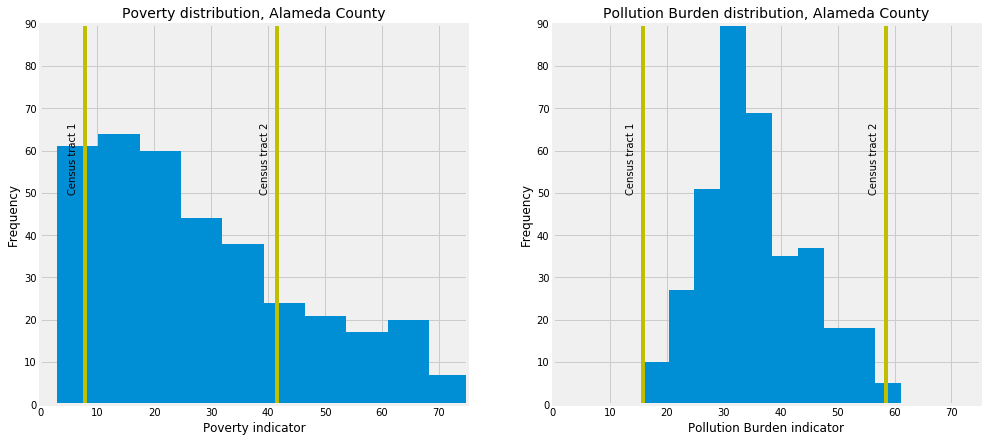

In [14]:
# SOLUTION (poverty hist)
plt.figure(figsize = (15,7))

plots = ['Poverty', 'Pollution Burden']

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(alameda_ft[plots[i]])
    plt.xlim(0,75)
    plt.ylim(0,90)
    plt.axvline(ind1[plots[i]].values, c = 'y')
    plt.text(ind1[plots[i]].values-3, 50, "Census tract 1", fontsize = 10, rotation = 90)
    plt.axvline(ind2[plots[i]].values, c = 'y')
    plt.text(ind2[plots[i]].values-3, 50, "Census tract 2", fontsize = 10, rotation = 90)
    plt.title(plots[i] + " distribution, Alameda County", fontsize = 14)
    plt.xlabel(plots[i] + " indicator")
    plt.ylabel("Frequency")

Lastly, let's take a look at the demographic profiles of these two communities. This data is stored in the `Demographic profile` sheet.

**Question 1.5** Similar to what we did earlier by comparing the two rows, compare the two tracts' demographic information (i.e. display the two rows together). We've loaded the sheet into a dataframe `dp` and have renamed the columns for you. In the cell below, load the demographic data corresponding to the first census tract in `demo1`, and the data corresponding to the second in `demo2`, much like we did right before question 1.5.

In [15]:
# load demographic profile
dp = xl.parse('Demographic profile', header = 1)
dp = dp.reset_index()
dp = dp.rename(columns = {'level_0': 'Census Tract',
                          'level_1': 'CES 3.0 Score',
                          'level_2': 'CES 3.0 Percentile',
                          'level_3': 'CES 3.0 Percentile Range',
                          'level_4': 'Total Population',
                          'level_5': 'California County'
    
})

In [17]:
# SOLUTION
demo1 = dp[dp['Census Tract'] == 6001421100.0]
demo2 = dp[dp['Census Tract'] == 6001422000.0]
demo1.append(demo2)

,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
7918,6001421100,1.473144,0.138731,1-5% (lowest scores),1992,Alameda,9.5,63.3,27.2,5.0,76.5,1.8,0.0,12.0,4.6
1908,6001422000,39.951507,75.936436,75-80%,1756,Alameda,9.1,82.5,8.4,12.6,43.3,28.0,0.2,10.0,5.9


If you're curious, you can take a look at where these census tracts are located by inputting the coordinates in [maps](https://www.google.com/maps).
- Coordinates for the first row: (+37.8994340, -122.2661928)
- Coordinates for second row: (+37.8590327, -122.3013426)

You can also use this [web tool](https://data.cityofberkeley.info/Demographics/Census-Tract-Polygons-2010/peq3-2arw) provided by the city of Berkeley to look at the area of each tract.

----

### Section 2: A decision tree from scratch <a name = 'scratch'></a>

Now that we've explored three different sheets in our original Excel file and are familiar with the data, we can move on to creating a decision tree from scratch. Even though trees are pretty easy to interpret, there's a lot that runs to create the final tree. We'll walk through creating a tree which will hopefully help our intuition when we use scikit-learn later in this homework.

First, let's take a very small subset of our data so that our tree will be easy to work with. There are a few things that we're going to do here to make this process more digestible -- we're taking a sample of 10 from the table and we are classifying the top and bottom groups of the CES dataset.

**Question 2.1** In this section, we'll go back to the dataframe `df0` (rather than looking at just the Alameda County data). In the cell below, we have one data-cleaning line that renames one of the columns we're going to use in building our decision tree - the percentile range of a given census tract. Then, we ouput the unique values for percentile range so that you can inspect the column.

In the cell below, you should create a new dataframe, `extremes`. It should contain data for tracts with the highest percentile score and lowest percentile score. For simplicity, your dataframe should only contain 3 columns: "Groundwater Threats", "Drinking Water", and "CES 3.0 Percentile Range".
</div>

In [18]:
# run this cell
df0.rename(columns={'CES 3.0 \nPercentile Range':'CES 3.0 Percentile Range'}, inplace = True)
df0['CES 3.0 Percentile Range'].unique()

array(['95-100% (highest scores)', '90-95%', '85-90%', '80-85%', '75-80%',
       '70-75%', '65-70%', '60-65%', '55-60%', '50-55%', '45-50%',
       '40-45%', '35-40%', '30-35%', '25-30%', '20-25%', '15-20%',
       '10-15%', '5-10%', '1-5% (lowest scores)', nan], dtype=object)

In [20]:
extremes = df0[(df0['CES 3.0 Percentile Range'] == '95-100% (highest scores)') 
               | (df0['CES 3.0 Percentile Range'] == '1-5% (lowest scores)')]

extremes = extremes[["Groundwater Threats", "Drinking Water","CES 3.0 Percentile Range"]]

extremes.head()

,Groundwater Threats,Drinking Water,CES 3.0 Percentile Range
0,45.75,681.195604,95-100% (highest scores)
1,36.00,904.657603,95-100% (highest scores)
2,30.25,681.195604,95-100% (highest scores)
3,132.10,278.756235,95-100% (highest scores)
4,54.20,1000.240794,95-100% (highest scores)


In [21]:
assert extremes.shape == (793, 3)

As you can probably guess from the dataframe `extremes`, we're going to build a tree that decides whether a census tract is in the lowest or highest percentile range of CalEnviroScreen scores based on the value of its Groundwater Threats and Drinking Water metrics.

When we build a tree, intuitively the first thing we need to do is decide how we'll create each split in the tree. In this section, we'll use the same criterion that scikit-learn uses when checking the "quality" of a split: the Gini index (also called Gini impurity). A low Gini index score indicates a near perfect split, and a high score means the composition of classes is nearly the same in both groups.

What does that mean? Let's say we create a split where any census tracts where Groundwater Threats < 3 are on one branch (branch #1), and any census tracts where Groundwater Threats are >= 3 are on another branch (branch #2). If branch #1 consists of only tracts in the highest percentile range, and branch #2 consists of only tracts in the lowest percentile range, this is a perfect split and will get a low Gini index for both branches. However, if branch #1 has a 50/50 split of tracts, and so does branch #2 (i.e. there are both high percentile and low percentile tracts with Groundwater Threats >= 3), then this is a pretty bad split that doesn't really help with classification, and it will get a high Gini index score for both branches.

The Gini index is calculated as follows:

$$ G = \sum_{k = 1}^{K}{\hat{p}_k(1 - \hat{p}_k)} = 1- \sum_{k = 1}^{K} (\hat{p}^2_k)$$

where $G$ is the Gini index, and $\hat{p}_k$ is the proportion of each response class in a split, and $K$ is the total number of response classes.

A separate Gini index is calculated for each branch of a split, and then a weighted Gini index can be calculated for the overall split, where the weight corresponds to the number of observations in each split.

**Question 2.2** Let's say we create a tree with one split, predicting a response variable with 2 classes (class 1 and class 2). We have 20 observations in total. One of the tree branches (branch #1) encompasses 3 observations of class 1 and 7 observations of class 2. The other tree branch (branch #2) encompasses 6 observations of class 1 and 4 observations of class 2. Calculate: 
1. The Gini index for branch #1
1. The Gini index for branch #2
1. The weighted Gini index

In [22]:
# solution
gini1 = 1-(3/10)**2-(7/10)**2
gini2 = 1-(6/10)**2-(4/10)**2
ginitotal = 0.5*gini1 + 0.5*gini2
print("branch 1:", gini1)
print("branch 2:", gini2)
print("weighted:", ginitotal)

branch 1: 0.4200000000000001
branch 2: 0.48
weighted: 0.45000000000000007


**Question 2.3** Take a look at the following cell, which contains the code to calculate the gini index. There are letters following three pound symbols. Write down what the lines of code below each letter are doing.

In [23]:
def gini_index(groups, classes):
    ### A ###
    n_instances = float(sum([len(group) for group in groups]))
    ### B ###
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        ### C ###
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        ### D ###
        gini += (1.0 - score) * (size / n_instances)
    return gini

***solution***
- a) count samples at split point
- b) sum weighted Gini index for each group
- c) score the group based on the score for each class
- d) weight the group score by its relative size

------

Now, we can work towards creating a split. Ultimately, we'll want to evaluate a range of possible splits using the Gini index. For now, we need a function that creates one split.

Splitting a dataset means separating a dataset into two lists based on how a feature (with a column number indicated by `index`) compare to a value (`value`). Once we have the two lists, we can use the Gini index above to evaluate the cost of the split, which will be implemented in a later function.

Run the following cell to load the function.

In [24]:
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

**Question 2.4** What does the group sorted in the right list represent?

**Solution**:  the right group contains all rows with a value at the index above or equal to the split value.

----
We can create our splits now. Given a dataset, we must check every value on each feature as a candidate split, evaluate the cost of the split using the Gini index and find the best possible split we can make. The lowest Gini score across all the features would then be chosen as the best split and a node would be created.

We will use a dictionary to represent a node in the decision tree. When selecting the best split and using it as a new node for the tree we will store the index of the chosen attribute, the value of that attribute by which to split and the two groups of data split by the chosen split point.

The function below runs this procedure. Run the cell to load function.

In [25]:
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index = index
                b_value = row[index]
                b_score = gini
                b_groups = groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

We have all of the tools to find the best splits of the tree -- let's see how we can use them to *build* one from the ground up (or from the top since trees are inverted...). 

Building a tree takes two main steps: finding leaves (e.g. when to stop the tree) and recursively splitting the tree.

The following cell contains the function that returns the most common output in a list of rows.

In [26]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

----

We're almost there! The following cell contains the function that performs the recursive splitting. 

Here are the steps of this procedure:

1. `split()` takes `node` as input, which is the dictionary returned by `get_split()`. The two lists of data returned by `get_split()` are extracted and deleted from the node. The node no longer requires access to these data.
2. We check if either left or right group of rows is empty and if so we create a terminal node using the data and computed scores we have.
3. Check if we have reached our maximum depth. If we have, create a terminal node.
4. If the left group of rows is too small, we process the left child and create a terminal node. Otherwise, we create and add the left node in a depth-first fashion until the bottom of the tree is reached on this branch.
5. Right side is then processed in the same manner, as we rise back up the constructed tree to the root.

**Question 2.5** Similar to question 2.2, look at the following cell and note what each control case is doing in the `split` function.

In [27]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    ### A ###
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    ### B ###
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    ### C ###
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    ### D ###
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

**Solution**
- a. check for an empty split
- b. check for max depth
- c. process left child
- d. process right child

----

Awesome! We're ready to build our tree. In the following cell, we have our `build_tree` and `print_tree` function. Most of the steps were abstracted away in `get_split` and `split` functions. Before we use the function, we can't directly use a pandas dataframe or series as input to this function.

**Question 2.6** In the same cell, convert `extremes` to a numpy array and assign it to the variable `rows`. Run the cell and see the resulting tree. What do the inequalities represent? How does it relate to the data we inputted into the tree?

In [28]:
# SOLUTION
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# YOUR CODE HERE       
rows = extremes.values
scratch_tree = build_tree(rows, 2, 2)
print_tree(scratch_tree)

[X2 < 493.979]
 [X1 < 22.750]
  [1-5% (lowest scores)]
  [95-100% (highest scores)]
 [X1 < 0.300]
  [1-5% (lowest scores)]
  [95-100% (highest scores)]


*Your answer here*

----

Just for fun, we can also use this tree for prediction. Run the following cell to see the expected and predicted values from our dataset!

In [32]:
# run this cell
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

for row in rows:
    prediction = predict(scratch_tree, row)
    print('Expected: ', row[-1])
    print('Got: ', prediction, '\n')

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  1-5% (lowest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  95-100% (highest scores) 

Expected:  95-100% (highest scores)
Got:  1-5% (lowest scores) 

Expected:  95-100% (highest scores)
Got:  1-5% (lowest scores) 

Expected:  95-100% (highest scores)
Got:  95-1

Expected:  1-5% (lowest scores)
Got:  95-100% (highest scores) 

Expected:  1-5% (lowest scores)
Got:  95-100% (highest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% (lowest scores)
Got:  1-5% (lowest scores) 

Expected:  1-5% 

Now that we have a better idea of how a tree works under the hood, let's move on to scikit-learn and create a more complex tree.

---

### Section 3. Implementing decision trees with scikit-learn<a name = 'sk'></a>

Since our data has quite a lot features, creating and tuning a tree from scratch would be a hassle and would not necessarily lead to optimal results. Here's where scikit-learn comes in and streamlines the process for us.

We'll be using scikit-learn's `DecisionTreeClassifier` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) in this section, and will use a larger subset of the data to create a more complex model.

In [29]:
# run this cell
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

df0.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


----
For our first model, we'll use the features to predict which score bracket a certain tract lies in - i.e. we want to predict the `CES 3.0 Percentile Range`. For the sake of interpretability, we'll focus on the 91st percentile and above, and the 10th percentile and below.

**Question 3.1** Before we move on, what is a problem that can stem from using such a specific subset of our data to build a classifier?

*Your Answer Here*

Let's take a look again at the scores that have been binned already in the dataset so we know how to set up our model. Run the following cell to see them!

In [29]:
df0['CES 3.0 Percentile Range'].unique()

array(['95-100% (highest scores)', '90-95%', '85-90%', '80-85%', '75-80%',
       '70-75%', '65-70%', '60-65%', '55-60%', '50-55%', '45-50%',
       '40-45%', '35-40%', '30-35%', '25-30%', '20-25%', '15-20%',
       '10-15%', '5-10%', '1-5% (lowest scores)', nan], dtype=object)

It looks like we have a total of four values that our tree can potentially classify if we want to take the top and bottom 10% of scores.

**Question 3.2** In the cell below, create a dataframe `pct_10_90` that contains rows with percentile tract in the `96-100% (highest scores)` and `91-95%` range, as well as the `6-10%` and `1-5% (lowest scores)`.

In [30]:
# SOLUTION
pct_10_90 = df0[(df0['CES 3.0 Percentile Range'] == '95-100% (highest scores)') 
   | (df0['CES 3.0 Percentile Range'] == '1-5% (lowest scores)')
   | (df0['CES 3.0 Percentile Range'] == '5-10%')
   | (df0['CES 3.0 Percentile Range'] == '90-95%')]

pct_10_90.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


In [31]:
assert len(pct_10_90['CES 3.0 Percentile Range'].unique()) == 4
assert pct_10_90.shape == (1585,57)

Now that we have our desired observations, let's filter through the certain features we want to use in our classification tree. Remember that a tree can use both continuous and categorical data, but we probably don't want to work with features like the county or zip code since it would clutter our data if we wanted to encode them. Run the following cell to drop the columns as well as the NaN values.

In [32]:
pct_10_90 = pct_10_90.drop(columns = ['Census Tract', 'CES 3.0 Score', ' CES 3.0 Percentile', 
                                      'California County', 'ZIP', 'Nearby City \n(to help approximate location only)', 
                                      'Longitude', 'Latitude', 'SB 535 Disadvantaged Community'])
pct_10_90 = pct_10_90.dropna()
pct_10_90.head()

,Total Population,CES 3.0 Percentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,3174,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6133,95-100% (highest scores),0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,3167,95-100% (highest scores),0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6692,95-100% (highest scores),0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,2206,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


The last thing we need to do before we create our decision tree is to drop the `Pctl` columns, as well as create the testing, training, and validation sets.

**Question 3.3** Create a dataframe `features` that contain our predictors. Drop all columns that contain the string `Pctl` for our set of features. Don't forget to drop the percentile range column. We don't want that in our features! 

Then, assign the percentile ranges to the variable `target`.

Lastly, create the training, testing, and validation sets by splitting the set into training and testing first, then split the training test into training and validation. Use `random_state = 1` both times, and create an 80/20 train/test split, and a 75/25 train/validation split.

*Note:* Here, `X_train` and `y_train` refer to the training set, while `X_val` and `y_val` are the validation set, and `X_test` and `y_test` are the test sets. `X` and `y` contain the training *and* validation sets, but they're just an intermediate variable in the code below. Throughout the lab, we'll be training models on `X_train` and `y_train` and using `X_val` and `y_val` to tune their parameters. Then, at the very very end, we'll look at how each model performs on `X_test` and `y_test`. Because we'll be doing cross-validation in some but not all cases, we're reserving the 'validation' data set now that will be used for benchmarking as we go along.  But in practice it's acting like a static test data set; the error reported from the validation data set is different from cross-validated error. 

In [33]:
#SOLUTION 
drop_columns = [i for i in pct_10_90.columns if 'Pctl' in i]
drop_columns.append('CES 3.0 Percentile Range')

features = pct_10_90.drop(columns=drop_columns)
target = pct_10_90['CES 3.0 Percentile Range']

# split test set
X, X_test, y, y_test = train_test_split(features, target, random_state = 1, test_size = .2)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1, test_size = 0.25)

In [34]:
assert features.shape[1] == X_test.shape[1] == 25
assert X_val.shape[0] == y_val.shape[0] == 299

Awesome! We can finally create a tree! 

**Question 3.4** Instantiate a `DecisionTreeClassifer` model and call it `first_tree`. Fit the model using the training data, and score it using both the training and validation set. Assign the scores to the variables `train_score` and `val_score` respectively. 

Remember: the general syntax for all scikit-learn models is the same, so if you're not sure where to start, take a look at the documentation for `DecisionTreeClassifier` as well as previous assignments that use scikit-learn models.

In [35]:
#SOLUTION
first_tree = DecisionTreeClassifier()
first_tree.fit(X_train, y_train)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(X_train, y_train)
val_score = first_tree.score(X_val, y_val)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 25
Number of nodes (internal and terminal): 109 

Train Score:  1.0
Validation Score:  0.9297658862876255


The score isn't too shabby for a tree that was put together pretty quickly. The nice part about decision trees is that they're easy to visualize and interpret and with scikit-learn, we can export the an image of the tree. Unfortunately, due limitations on DataHub, we can't output an image directly in a notebook. 

Luckily, we can copy the code and visualize the tree on [Webgraphviz](http://webgraphviz.com). By running the following cell, you'll see a pretty long output -- follow the link and copy and paste the output to get a visualization of the decision tree we fit!

In [43]:
import graphviz
print(tree.export_graphviz(first_tree, feature_names=X.columns))

digraph Tree {
node [shape=box] ;
0 [label="Pop. Char. Score <= 5.396\ngini = 0.749\nsamples = 896\nvalue = [220, 206, 237, 233]"] ;
1 [label="Pop. Char. Score <= 1.545\ngini = 0.499\nsamples = 426\nvalue = [220, 206, 0, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Pollution Burden <= 37.23\ngini = 0.247\nsamples = 166\nvalue = [142, 24, 0, 0]"] ;
1 -> 2 ;
3 [label="Cardiovascular Disease <= 2.28\ngini = 0.033\nsamples = 119\nvalue = [117, 2, 0, 0]"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]"] ;
3 -> 4 ;
5 [label="Pollution Burden <= 36.201\ngini = 0.017\nsamples = 118\nvalue = [117, 1, 0, 0]"] ;
3 -> 5 ;
6 [label="gini = 0.0\nsamples = 109\nvalue = [109, 0, 0, 0]"] ;
5 -> 6 ;
7 [label="Linguistic Isolation <= 2.85\ngini = 0.198\nsamples = 9\nvalue = [8, 1, 0, 0]"] ;
5 -> 7 ;
8 [label="gini = 0.0\nsamples = 8\nvalue = [8, 0, 0, 0]"] ;
7 -> 8 ;
9 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]"] ;
7 -> 9 ;
10 [label="Pop. 

**Question 3.5** What does each line in a given box in the Webgraphviz visualization represent?

***YOUR ANSWER HERE*** <br>
First line:

Second line:

Third line:

Fourth Line:

**Question 3.6** Based on the visualization:
1. What are the problems or pitfalls with the model we just created? 
1. Can you infer the "most" and "least" important features?

*Your answer here*

----
With scikit-learn, we're also able to check the feature importance. Running the following cell, we can see the features and the their importance based on the data we used to fit the tree -- this can be helpful when tuning or pruning the tree! The feature importance is a measure of how much of a decrease in the Gini index results from including that feature.

In [44]:
pd.DataFrame({'Feature': X.columns, 'Importance': first_tree.feature_importances_})

,Feature,Importance
0,Total Population,0.013680
1,Ozone,0.000000
2,PM2.5,0.002234
3,Diesel PM,0.000000
4,Drinking Water,0.000683
5,Pesticides,0.000000
6,Tox. Release,0.000000
7,Traffic,0.000000
8,Cleanup Sites,0.001303
9,Groundwater Threats,0.000000


-----
We've had a good look at what we can do with a decision tree in using scikit-learn. Let's dive into learning about the hyperparameters, which can help improve our classification model. Again, the documentation for `DecisionTreeClassifier` is linked [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

If you noticed in the tree earlier, there were a *lot* of nodes. Some of these nodes have a gini score of 0 or have small sample numbers. We can overcome these problems by tweaking the hyperparameters of the tree. 

**Quesiton 3.7** In the following cell, we have almost the exact same code from earlier, but we've added two parameters: `max_leaf_nodes` and `max_features`. Try two or three sets of different values for these two parameters and see if we can improve our original model.

In [36]:
# possible solution
tuned_tree = DecisionTreeClassifier(max_leaf_nodes=5, max_features=25)
tuned_tree.fit(X_train, y_train)

print("Number of features: {}".format(tuned_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(tuned_tree.tree_.node_count),"\n")

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Number of features: 25
Number of nodes (leaves): 9 

Train Score:  0.7667410714285714
Validation Score:  0.7391304347826086


Were you able to obtain validation score higher than what we had originally (it's ok if you didn't!)? It probably took some time to figure out which values were better than others.

Fortunately, we don't have to test various parameters by manually inputting them and running the cell, which would be exhausting! Instead, we can use [`RandomizedSearchCV` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to help us find optimal parameters. 

It takes in a model, a distribution of parameters we want to test in the model, and other parameters that we can tweak. We'll only use `cv` and `n_iter` along with the two required arguments. 

The parameter distribution is a dictionary that takes in the parameter name as a key and a range of random values that we want to test. We'll be using `randint` from scipy.stats. Run the following cell -- we will also fit the CV search which will take some time.

In [39]:
# run this cell
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10)}

rnd_search = RandomizedSearchCV(tuned_tree, param_distributions=param_dist, 
                                cv=10, n_iter=200, random_state = 2)
rnd_search.fit(X_train, y_train)

/srv/app/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=25,
                                                    max_leaf_nodes=5,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'),
  

After fitting our data, we can check the score and the values for the parameters that return the "best" score. Run the following cell to get these values!

In [47]:
print(rnd_search.best_score_) # This is cross validation error from the training data set.
print(rnd_search.best_params_)

0.9017857142857143
{'max_depth': 8, 'max_features': 22, 'max_leaf_nodes': 28}


**Question 3.8** With our new parameters, set the parameters of `tuned_tree` to the 3 parameters that we found using the randomized search. Then, score the model using the training and validation sets.

In [48]:
#SOLUTION
tuned_tree.set_params(max_features=20, max_leaf_nodes=29, max_depth = 7)
tuned_tree.fit(X_train, y_train)

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Train Score:  0.9754464285714286
Validation Score:  0.939799331103679


Awesome! Hopefully this tuned tree performed better than our original one (due to the random samples, it's hard to say). Let's also print out the feature scores like we did initially. Do you see a difference between the feature importances of the tuned tree compared to those of the first tree?

In [49]:
pd.DataFrame({'Feature':X_train.columns, 'Importance': tuned_tree.feature_importances_})

,Feature,Importance
0,Total Population,0.006128
1,Ozone,0.000000
2,PM2.5,0.000000
3,Diesel PM,0.000000
4,Drinking Water,0.000000
5,Pesticides,0.000000
6,Tox. Release,0.000000
7,Traffic,0.000000
8,Cleanup Sites,0.000000
9,Groundwater Threats,0.000000


Lastly, for this tuned tree, let's take a look at how adjusting the hyperparameters altered the decision tree. Like last time, copy and paste the code into [Webgraphviz](http://webgraphviz.com) to visualize the tree.

In [50]:
print(tree.export_graphviz(tuned_tree, feature_names=X.columns))

digraph Tree {
node [shape=box] ;
0 [label="Pop. Char. Score <= 5.396\ngini = 0.749\nsamples = 896\nvalue = [220, 206, 237, 233]"] ;
1 [label="Pop. Char. Score <= 1.545\ngini = 0.499\nsamples = 426\nvalue = [220, 206, 0, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
3 [label="Pollution Burden <= 37.23\ngini = 0.247\nsamples = 166\nvalue = [142, 24, 0, 0]"] ;
1 -> 3 ;
17 [label="gini = 0.033\nsamples = 119\nvalue = [117, 2, 0, 0]"] ;
3 -> 17 ;
18 [label="Pop. Char. Score <= 1.095\ngini = 0.498\nsamples = 47\nvalue = [25, 22, 0, 0]"] ;
3 -> 18 ;
19 [label="gini = 0.08\nsamples = 24\nvalue = [23, 1, 0, 0]"] ;
18 -> 19 ;
20 [label="gini = 0.159\nsamples = 23\nvalue = [2, 21, 0, 0]"] ;
18 -> 20 ;
4 [label="Pollution Burden Score <= 3.293\ngini = 0.42\nsamples = 260\nvalue = [78, 182, 0, 0]"] ;
1 -> 4 ;
9 [label="Pop. Char. Score <= 2.089\ngini = 0.5\nsamples = 140\nvalue = [69, 71, 0, 0]"] ;
4 -> 9 ;
11 [label="gini = 0.041\nsamples = 48\nvalue = [47, 1, 0, 0]"] ;
9 -

Let's move on to more improvements we can make to decision tree models.

----

### Section 4: Ensemble methods<a name = 'improve'></a>

In the previous section, we mainly were focusing on fitting one tree and tuning its hyperparameters. You may have noticed that, although the training scores were extremely high, the validation scores usually weren't as high. This is where ensemble methods come in, namely bagging, random forests, and boosting. We call them "ensemble methods" because we fit many trees and we somehow aggregate the models to avoid overfitting - in bagging, for example, we take an average of models. The benefits of using ensemble methods may not be immediately apparent with the training and validation data, but might become clearer when we evaluate all our models on the test data at the end of the assignment.

----

Let's start with bagging!

Bagging takes in $B$ different bootstrapped training data sets and we train our tree on each $b$th training set to get $\hat{f}^{*b}(x)$. Then, we average all of the predictions to get 

$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B}\hat{f}^{*b}(x)$$

In terms of classifying, bagging records the class from each bootstrapped sample and chooses the most commonly occurring majority class among the B predictions.

Let's proceed by using `BaggingClassifier` from scikit-learn's ensemble module ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)). 

**Question 4.1** Use the training data `X_train` and fit the bagging classifier. Call your model `bag_tree`. Score the model on the validation data -- has the score improved on the training or validation data?  Use `n_estimators = 100`, `max_samples = 700`, `max_features = 25`.


*Note:* We're not specifying a `random_state` to use with `BaggingClassifier()` here, but if you want your results to be reproducible you may want to set one.

In [37]:
# solution
from sklearn.ensemble import BaggingClassifier

bag_tree = BaggingClassifier(random_state = 10, n_estimators = 100, max_samples = 700, max_features = 25)
bag_tree.fit(X_train, y_train)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  1.0
Validation Score:  0.919732441471572


**Question 4.2**  Note that as opposed to the "standard" tree we fit before, we're not cross-validating any parameters.  Why?

*Your answer here*

**Question 4.3** What are some drawbacks of bagging compared to a single decision tree? Describe one way to compare the quality of a single decision tree model to a bagged model.

*Your answer here*

----
Now, we'll move on to random forests.

Random forests take a similar approach to bagging, in which we fit various decision trees on resampled data. But, when each tree is constructed, not every feature is considered as split candidates for each decision point; we only take a subset of the total predictors in the model.

The idea behind a random forest is that adding randomization into the features that create the model and then averaging predictions across models will produce a model that is not as overfit to the training data, and is in turn more reliable for prediction.

We'll use scikit-learn's `RandomForestClassifier()` to implement our model. The documentation can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Question 4.4** Create a default RandomForestClassifier and same as before, fit the training data and score the model. Call the model `rf_tree`.

In [54]:
# solution
from sklearn.ensemble import RandomForestClassifier

rf_tree = RandomForestClassifier()
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  0.9955357142857143
Validation Score:  0.8729096989966555


/srv/app/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Question 4.5** Review the sklearn documentation on random forests to identify what hyperparameters might improve model performance.  In particular, what is `max_depth`, and what should you choose it to be? (You might want to consult with lecture notes and the textbook for guidance.) 

*Your answer here*

**Question 4.6** Decide what other hyperparameters will affect model performance (things like tree depth, maximum number of observations per leaf, etc).  Choose values for those parameters and pass them in to a new random forest classifier and fit the model, then print out errors with training and validation data. Call your model `rf_newparams`.

In [56]:
#solution
rf_newparams = RandomForestClassifier(max_features="auto", max_leaf_nodes = None,
                    min_samples_leaf=1, min_samples_split=2, n_estimators=100, 
                    random_state = 3)
rf_newparams.fit(X_train, y_train)

rf_train_score = rf_newparams.score(X_train, y_train)
rf_val_score = rf_newparams.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  1.0
Validation Score:  0.9264214046822743


Similar to bagging, we cannot visualize a random forest; the reduction in variance comes at the price of interpretability. 

----
Lastly, we'll cover boosting, which is yet another approach to improve a decision tree model. The boosting approach grows a tree slowly. Each boosting algorithm has a slightly different approach, but the general idea is the same behind each one.

First, we'll briefly cover AdaBoost (for ADAptive BOOSTing). The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence; it combines many relatively weak and inaccurate classifiers. So it shines when a regular classifier doesn't perform well with a given dataset.

We can use `AdaBoostClassifier` from scikit-learn to try this out. Run the following cell to see how it performs.

In [57]:
from sklearn.ensemble import AdaBoostClassifier

ada_tree = AdaBoostClassifier()
ada_tree.fit(X_train, y_train)

ada_train_score = ada_tree.score(X_train, y_train)
ada_val_score = ada_tree.score(X_val, y_val)

print('Train Score: ', ada_train_score)
print('Validation Score: ', ada_val_score)

Train Score:  0.5100446428571429
Validation Score:  0.4916387959866221


Oops. It doesn't look too great. One thing with AdaBoost is that it doesn't handle noisy data or outliers well. In this case, our data is basically polarized -- we're taking values from the top and bottom 10% -- which means it might not work as well as we want it to.

We can turn to gradient boosting, which is another boosting method. Gradient boosting involves three elements:
1. A loss function to be optimized.
2. A weak learner to make predictions.
3. An additive model in which we add weak learners to minimize the loss function.

We'll use scikit-learn's `GradientBoostingClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to see how it performs with our data.

**Question 4.7** We'll do this for the last time! Fit the training data to the GradientBoostingClassifier and score the model. How much did it improve over the original model?

In [41]:
# solution
from sklearn.ensemble import GradientBoostingClassifier

gb_tree = GradientBoostingClassifier()
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

Train Score:  1.0
Validation Score:  0.9331103678929766


**Question 4.8** In the case of boosting, cross validation helps for hyperparameter tuning.  Figure out what parameters you'd like to search over, choose a range for them, and pass them into `RandomizedSearchCV` as we did in part 3.  Then save and print out the best parameters. (this will probably take a while to run, depending on how many parameters you choose!)

In [42]:
%%time

param_dist = {'learning_rate': randint(1, 5),
              #'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30)}

rnd_gb_search = RandomizedSearchCV(gb_tree, param_distributions=param_dist, 
                                cv=10, n_iter=50)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

/srv/app/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1, 'max_depth': 8, 'max_features': 13, 'min_samples_leaf': 7}
CPU times: user 7min 20s, sys: 389 ms, total: 7min 20s
Wall time: 7min 21s


**Question 4.9** Once the search is complete, set the parameters and re-fit and score the model.

In [62]:
# SOLUTION
gb_tree.set_params(learning_rate=.1, max_depth=5, max_features=18, max_leaf_nodes=47, 
                   min_samples_leaf=9)
gb_tree.fit(X_train, y_train)

print('Train Score: ', gb_tree.score(X_train, y_train))
print('Validation Score: ', gb_tree.score(X_val, y_val))

Train Score:  1.0
Validation Score:  0.9431438127090301


With boosting, we can also find the relative feature importance with this boosted model. This can help with the feature importance like before. 

**Question 4.10**  Get the feature importances and calculate the *relative* feature importance, which is each feature divided by the maximum feature importance multiplied by 100. Load the data into a table called `gb_feat`.

In [64]:
# SOLUTION
feature_importance = gb_tree.feature_importances_
#relative feature importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
gb_feat = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})

In [65]:
# run this cell to display gb_feat
gb_feat

,feature,importance
0,Total Population,1.075208
1,Ozone,0.092493
2,PM2.5,0.095292
3,Diesel PM,0.294184
4,Drinking Water,0.338599
5,Pesticides,0.146532
6,Tox. Release,0.074052
7,Traffic,0.146383
8,Cleanup Sites,1.367732
9,Groundwater Threats,0.459001


**Question 4.11** Let's take a look at how these features compare with each other. Sort the values in the dataframe and create a bar chart that displays the feature importances in descending order.

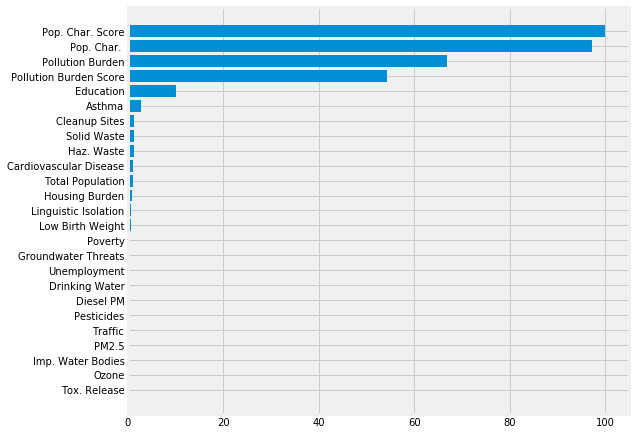

In [67]:
# SOLUTION
gb_feat = gb_feat.sort_values(by='importance', ascending=True)

plt.figure(figsize=(8, 7.5))
plt.barh(width=gb_feat.importance, y=gb_feat.feature);

----

We've gone through many methods of creating a decision tree and tuning and improving it, as well as various algorithms that use multiple trees to create a more reliable tree for prediction. Even though we've primarily have been testing our models with the training and validation set, we would still need to cross validate each of these models to see which one is the optimal one to choose given our data and how the model performs (this is even more important when a lot of the scores turned up around 92-93%). 

Before you finish up this homework, run the following cell to see which has the highest score with our test set!

In [68]:
models = [first_tree, tuned_tree, bag_tree, rf_tree, rf_newparams, ada_tree, gb_tree]
for i in models:
    print('Test Score: ', i.score(X_test, y_test))

Test Score:  0.8896321070234113
Test Score:  0.919732441471572
Test Score:  0.9264214046822743
Test Score:  0.8561872909698997
Test Score:  0.9063545150501672
Test Score:  0.4816053511705686
Test Score:  0.9531772575250836


### Section 5: Project<a name = 'project'></a>

**Question 5.1** Think of a way to apply classification methods to the data and problem area that you're exploring through your project. What would your response variable be? Is there any policy or real-world motivation for applying a classification  method in this way?

*Note*: you don't have to use classification in your project, but it's useful to think through how you might. You don't have to predict a variable that's already qualitative - you can also think of how to bin quantitative data into different classes. 

*Your answer here*

----

## Submission

Congrats, you're done with homework 9! 

In order to turn in this assignment, go to the toolbar and click **File** -> **Download as** -> **.html** and **.ipynb**. Submit the files through bCourses.

----

Notebook developed by: Jason Jiang

Data Science Modules: http://data.berkeley.edu/education/modules